In [5]:
import numpy as np
import pandas as pd
from pathlib import Path
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import os
pd.set_option('display.float_format', lambda x: '%.9f' % x)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [6]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.000000000,3401.000000000,3398.000000000,3401.000000000,nan,3401.000000000,2.000000000,1.000000000
1976-08-03,3401.000000000,3401.000000000,3401.000000000,3401.000000000,nan,3401.000000000,0.000000000,1.000000000
1976-08-04,3401.000000000,3401.000000000,3401.000000000,3401.000000000,nan,3401.000000000,0.000000000,1.000000000
1976-08-05,3401.000000000,3401.000000000,3401.000000000,3401.000000000,nan,3401.000000000,0.000000000,1.000000000
1976-08-06,3401.000000000,3401.000000000,3401.000000000,3401.000000000,nan,3401.000000000,0.000000000,1.000000000


In [7]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.000000000,6954.000000000,6835.000000000,6847.000000000,nan,6847.000000000,48336.000000000,51473.000000000
1990-01-03,6877.000000000,6910.000000000,6865.000000000,6887.000000000,nan,6887.000000000,38206.000000000,53860.000000000
1990-01-04,6937.000000000,7030.000000000,6924.000000000,7008.000000000,nan,7008.000000000,49649.000000000,55699.000000000
1990-01-05,6952.000000000,6985.000000000,6942.000000000,6950.000000000,nan,6950.000000000,29944.000000000,53111.000000000
1990-01-08,6936.000000000,6972.000000000,6936.000000000,6959.000000000,nan,6959.000000000,19763.000000000,52072.000000000


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

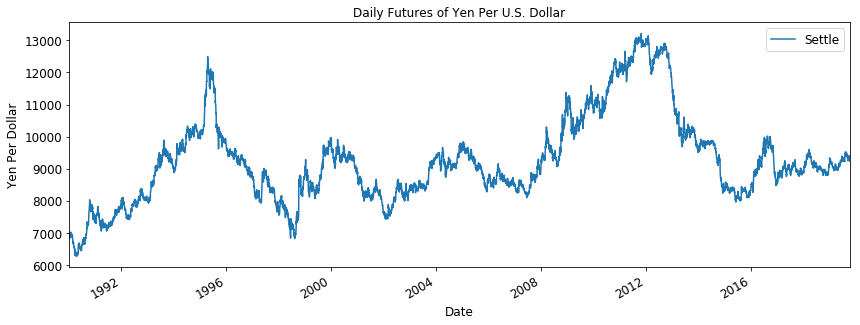

In [8]:
# Plot just the "Settle" column from the dataframe:
# YOUR CODE HERE!
ax = yen_futures.Settle.plot(legend = True, title = 'Daily Futures of Yen Per U.S. Dollar', figsize = (14,5), fontsize = 12)
ax.set_ylabel('Yen Per Dollar', fontsize = 12)
ax.set_xlabel('Date', fontsize = 12)
ax.legend(fontsize = 12)
plt.show()

*Answer*
 * Based on the plot above, we can see a long-term strengthening of the Japanese Yen against the Dollar. There do seem to be some more medium, 1-3 year consistent trends, but on a daily basis, there are a lot of short-term ups and downs.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [10]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
# YOUR CODE HERE!
ts_noise, ts_trend =  sm.tsa.filters.hpfilter(yen_futures['Settle'])

In [13]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
# YOUR CODE HERE!
futures_decomp = yen_futures[["Settle"]].copy()
futures_decomp["Noise"] =  ts_noise 
futures_decomp["Trend"] =  ts_trend 
futures_decomp.head()

,Settle,Noise,Trend
Date,,,
1990-01-02,6847.000000000,-61.503966971,6908.503966971
1990-01-03,6887.000000000,-21.799755631,6908.799755631
1990-01-04,7008.000000000,98.942895689,6909.057104311
1990-01-05,6950.000000000,40.776051814,6909.223948186
1990-01-08,6959.000000000,49.689938262,6909.310061738


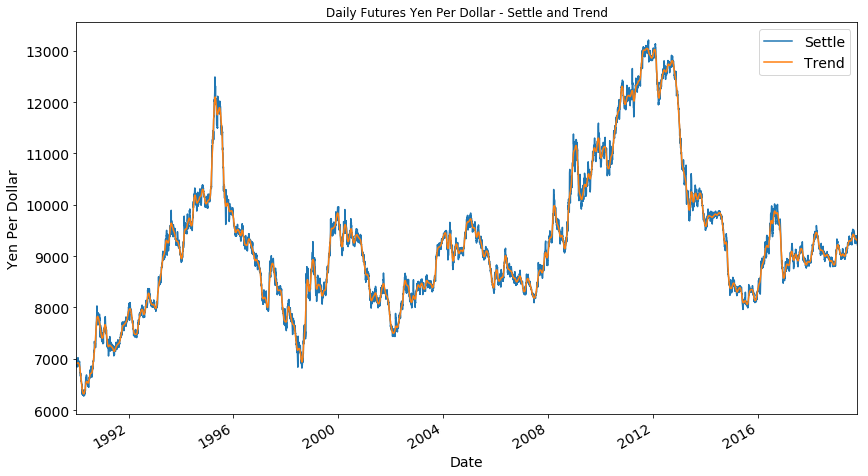

In [14]:
# Plot the Settle Price vs. the Trend
# YOUR CODE HERE!
ax = futures_decomp.plot(y = ['Settle', 'Trend'], title ='Daily Futures Yen Per Dollar - Settle and Trend', figsize = (14,8), fontsize = 14)
ax.set_ylabel('Yen Per Dollar', fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.legend(fontsize = 14)
plt.show()

Smoothing with the HP Filter and plotting the resulting trend against the actual futures returns, we can see that there's a lot of short term fluctuations that deviate around this trend. Perhaps these would represent profitable trading opportunities: For example, when the blue line deviates far below the orange, we can see this as a sign that the Yen is temporarily more undervalued than it should be (and, therefore, we'd see this as a short-term buying opportunity).

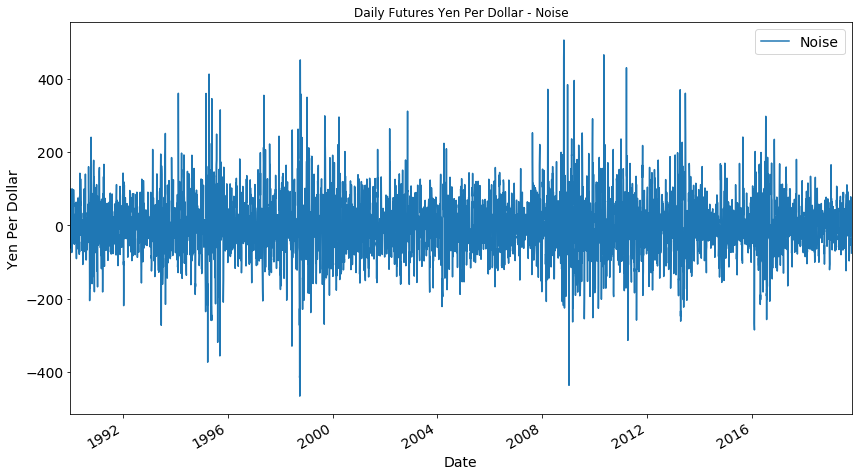

In [15]:
# Plot the Settle Noise
# YOUR CODE HERE!
ax = futures_decomp.plot(y = 'Noise', title = 'Daily Futures Yen Per Dollar - Noise', figsize = (14,8), fontsize = 14)
ax.set_ylabel('Yen Per Dollar', fontsize = 14)
ax.set_xlabel('Date', fontsize = 14)
ax.legend(fontsize = 14)
plt.show()

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [16]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410600971
2019-10-10,-0.369458128
2019-10-11,-0.564303757
2019-10-14,0.151334991
2019-10-15,-0.469508904


In [28]:
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm

# Estimate and ARMA model using statsmodels (use order=(2, 1))
# YOUR CODE HERE!
# Fit the model and assign it to a variable called results
# YOUR CODE HERE!
autoregressive_count = 2
moving_average_window = 1
model = ARMA(returns, order =(autoregressive_count,moving_average_window))
results = model.fit()

In [29]:
# Output model summary results:
# YOUR CODE HERE!
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Settle   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Wed, 15 Jul 2020   AIC                          15798.142
Time:                        18:42:36   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0064      0.008      0.804      0.421      -0.009       0.022
ar.L1.Settle    -0.3061      1.278     -0.240      0.811      -2.810       2.198
ar.L2.Settle    -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.Settle     0.2945      1.278      0.231      0.818      -2.210       2.799
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3362           +0.0000j            3.3362            0.5000
AR.2         -157.1918           +0.0000j          157.1918            0.5000
MA.1           -3.3952           +0.0000j            3.3952            0.5000
-----------------------------------------------------------------------------
"""

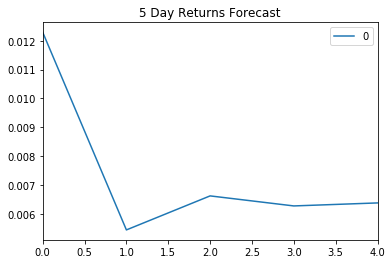

In [47]:
# Plot the 5 Day Returns Forecast
# YOUR CODE HERE!
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

Question: Based on the p-value, is the model a good fit?

Answer:

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [25]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
# YOUR CODE HERE!

df = yen_futures [['Settle']]
df.head()
# Fit the model
# YOUR CODE HERE!
model = ARIMA(df, order =(5, 1, 1))
model_fit = model.fit()

In [26]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Settle   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Wed, 15 Jul 2020   AIC                          15798.142
Time:                        18:40:11   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0064      0.008      0.804      0.421      -0.009       0.022
ar.L1.Settle    -0.3061      1.278     -0.240      0.811      -2.810       2.198
ar.L2.Settle    -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.Settle     0.2945      1.278      0.231      0.818      -2.210       2.799
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3362           +0.0000j            3.3362            0.5000
AR.2         -157.1918           +0.0000j          157.1918            0.5000
MA.1           -3.3952           +0.0000j            3.3952            0.5000
-----------------------------------------------------------------------------
"""

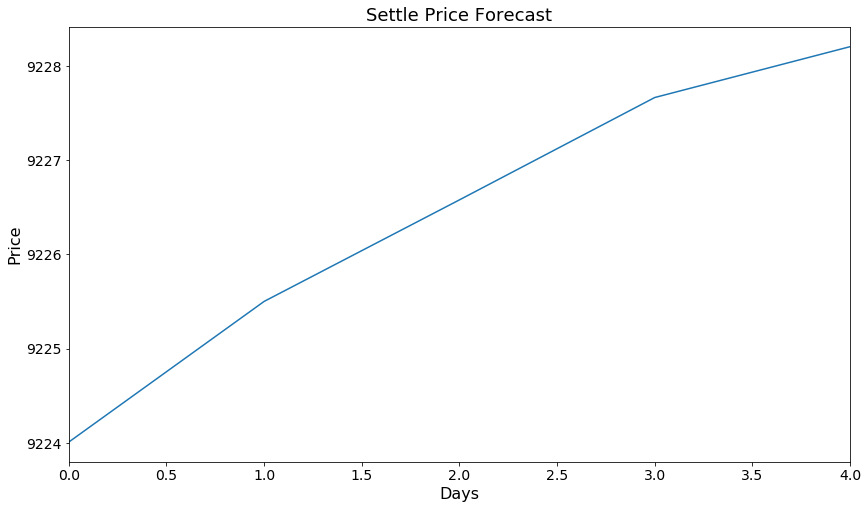

In [30]:
# Plot the 5 Day Price Forecast
# YOUR CODE HERE!
ax = pd.DataFrame(model_fit.forecast(steps = 5)[0]).plot(fontsize = 14, figsize = (14,8), legend = False)
ax.set_xlabel('Days', fontsize = 16)
ax.set_title('Settle Price Forecast',fontsize = 18)
ax.set_ylabel('Price', fontsize = 16)
plt.show()

What does the model forecast will happen to the Japanese Yen in the near term?

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [31]:
import arch as arch
from arch import arch_model

In [34]:
# Estimate a GARCH model:
# YOUR CODE HERE!
# Fit the model
# YOUR CODE HERE!
am = arch_model(returns, mean = 'Zero', vol = 'GARCH', p = 2, q = 1)
res = am.fit(disp = 'off')

In [35]:
# Summarize the model results
# YOUR CODE HERE!
print(res.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Wed, Jul 15 2020   Df Residuals:                     7510
Time:                        18:45:04   Df Model:                            4
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.708e-02 

In [36]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [38]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
# YOUR CODE HERE!
forecasts = res.forecast(start = last_day, horizon = forecast_horizon)
forecasts

In [39]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434047680,7.475744606,7.516866589,7.557425857,7.597434223


In [40]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15 00:00:00
h.1,7.434047680
h.2,7.475744606
h.3,7.516866589
h.4,7.557425857
h.5,7.597434223


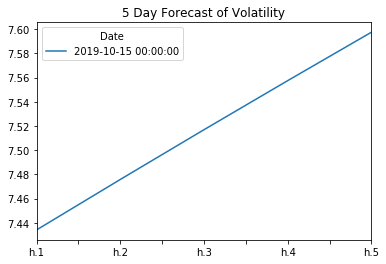

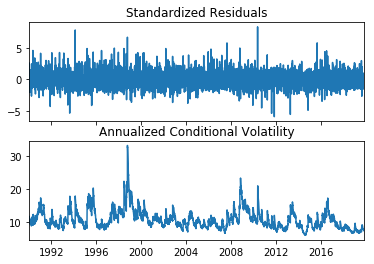

In [48]:
# Plot the final forecast
# YOUR CODE HERE!
final.plot(title='5 Day Forecast of Volatility', legend=True)
fig = res.plot(annualize = 'D')

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?